In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys 
import configparser
import pandas as pd 
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from matplotlib import cycler
from os.path import join as oj
from torch.utils.data import TensorDataset, DataLoader
import pickle as pkl
from sklearn.preprocessing import StandardScaler,MinMaxScaler
sys.path.insert(0, "../src")
import severson_data
import snl_data
import models
import seaborn as sns
import pickle as pkl
pd.set_option('display.float_format', lambda x: '%.2f' % x)
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

In [3]:
colours = ['#208F90', '#8F2317','#17608F','#8F5F17','#f2f3f4','#E56399','#DE6E4B']
golden_ratio =1.618

sns.set_palette(sns.color_palette(colours))


colors = cycler('color',
                colours)
plt.rc('axes', facecolor='#FFFFFF', edgecolor='#000000',
       axisbelow=True, grid=True, prop_cycle=colors)

In [4]:
config = configparser.ConfigParser()
config.read('../config.ini');
result_path =config['PATHS']['result_path'] 

In [5]:
model_path  =config['PATHS']['result_path'] 
fig_path =config['PATHS']['figure_path'] 
fnames = sorted([oj(model_path, fname) for fname in os.listdir(model_path) if "pkl" in fname]) 
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 


In [8]:
snl_dict = pkl.load(
        open(oj(config['DATASET']['data_path'], 'snl_curated_data.pkl'), "rb"))
snl_dict = {
        key: val
        for key, val in snl_dict.items()
        if 'LFP' != snl_dict[key]['Cathode chemistry']
    }

In [11]:
snl_dict.keys()

dict_keys(['SNL_18650_NCA_15C_0-100_0.5-1C_a', 'SNL_18650_NCA_15C_0-100_0.5-1C_b', 'SNL_18650_NCA_15C_0-100_0.5-2C_a', 'SNL_18650_NCA_15C_0-100_0.5-2C_b', 'SNL_18650_NCA_25C_0-100_0.5-0.5C_a', 'SNL_18650_NCA_25C_0-100_0.5-0.5C_b', 'SNL_18650_NCA_25C_0-100_0.5-1C_a', 'SNL_18650_NCA_25C_0-100_0.5-1C_b', 'SNL_18650_NCA_25C_0-100_0.5-1C_c', 'SNL_18650_NCA_25C_0-100_0.5-1C_d', 'SNL_18650_NCA_25C_0-100_0.5-2C_a', 'SNL_18650_NCA_25C_0-100_0.5-2C_b', 'SNL_18650_NCA_35C_0-100_0.5-1C_a', 'SNL_18650_NCA_35C_0-100_0.5-1C_b', 'SNL_18650_NCA_35C_0-100_0.5-1C_c', 'SNL_18650_NCA_35C_0-100_0.5-1C_d', 'SNL_18650_NCA_35C_0-100_0.5-2C_a', 'SNL_18650_NCA_35C_0-100_0.5-2C_b', 'SNL_18650_NMC_15C_0-100_0.5-1C_a', 'SNL_18650_NMC_15C_0-100_0.5-1C_b', 'SNL_18650_NMC_15C_0-100_0.5-2C_a', 'SNL_18650_NMC_15C_0-100_0.5-2C_b', 'SNL_18650_NMC_25C_0-100_0.5-0.5C_a', 'SNL_18650_NMC_25C_0-100_0.5-0.5C_b', 'SNL_18650_NMC_25C_0-100_0.5-1C_a', 'SNL_18650_NMC_25C_0-100_0.5-1C_b', 'SNL_18650_NMC_25C_0-100_0.5-1C_c', 'SNL_1865

In [118]:
x,y, c, var = snl_data.load_data()

C:\Users\lauri\AppData\Roaming\Python\Python39\site-packages\scipy\interpolate\interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\lauri\AppData\Roaming\Python\Python39\site-packages\scipy\interpolate\interpolate.py:608: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


In [131]:
x = snl_data.scale_x(x)
old_x = x.copy()

In [132]:
x = snl_data.remove_outliers(x, y)

In [135]:
smoothed_x = severson_data.smooth_x(x, y, num_points=20)

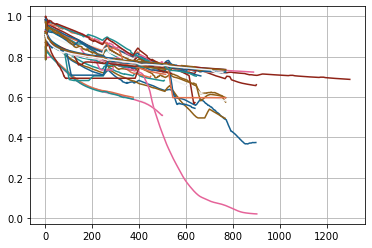

In [141]:
for i in range(40):
    plt.plot(smoothed_x[i, :y[i]-10])

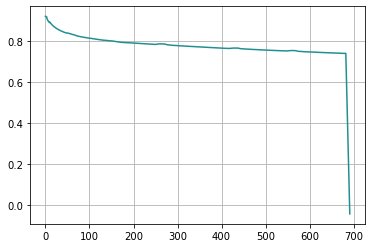

In [138]:
my_idx = 32
plt.plot(smoothed_x[my_idx, :y[my_idx]])

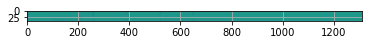

In [96]:
plt.imshow(x-old_x)

In [84]:
x[:,0].min()

2.5789999999999997

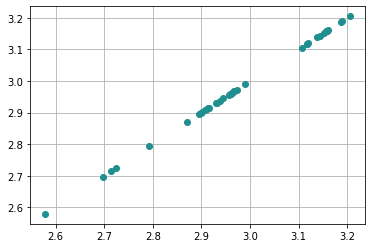

In [81]:
plt.scatter(x[:,0],x[:,0])

In [79]:
x[:,0].max()

3.205

In [61]:
num_bats = len(snl_dict.keys())

In [62]:
num_bats


40

In [58]:
max_lifetime = max([len(snl_dict[key]['Max Qdischarge [Ah]']) for key in snl_dict.keys()])

In [59]:
[len(snl_dict[key]['Max Qdischarge [Ah]'])]

[768]

In [60]:
max_lifetime

1310

In [52]:
cur_bat.keys()

dict_keys(['Cell geometry', 'Cathode chemistry', 'Temperature', 'SOL interval', 'Charging rate', 'Discharging rate', 'Cycles', 'Max Qdischarge [Ah]', '10th Vch [V]', '10th Ich [A]', '10th Qch [Ah]', '10th Vdch [V]', '10th Idch [A]', '10th Qdch [Ah]', '100th Vch [V]', '100th Ich [A]', '100th Qch [Ah]', '100th Vdch [V]', '100th Idch [A]', '100th Qdch [Ah]', 'overpotential', 'c_eff', 'var'])

In [75]:
for key in snl_dict.keys():
    print(snl_dict[key]['Discharging rate'][:-1])
#     overpotential_10 = snl_dict[key]['10th Vch [V]'].mean() - snl_dict[key]['10th Vdch [V]'].mean()
#     overpotential_100 = snl_dict[key]['100th Vch [V]'].mean() - snl_dict[key]['100th Vdch [V]'].mean()
#     snl_dict[key]['overpotential'] = overpotential_100 - overpotential_10
#     c_eff_10 = snl_dict[key]['10th Qdch [Ah]'].max()
#     c_eff_100 = snl_dict[key]['100th Qdch [Ah]'].max()
#     snl_dict[key]['c_eff'] = c_eff_100 - c_eff_10
#     cur_bat = snl_dict[key]
    
#     min_voltage = np.maximum(cur_bat['100th Vdch [V]'].min(), cur_bat['10th Vdch [V]'].min())
#     max_voltage = np.minimum(cur_bat['100th Vdch [V]'].max(), cur_bat['10th Vdch [V]'].max())
#     start_curve = get_capacity_spline(cur_bat, min_voltage, max_voltage, use_tenth = True)
#     stop_curve = get_capacity_spline(cur_bat, min_voltage, max_voltage, use_tenth = False)
#     snl_dict[key]['var'] = (start_curve - stop_curve).var()
    

1
1
2
2
0.5
0.5
1
1
1
1
2
2
1
1
1
1
2
2
1
1
2
2
0.5
0.5
1
1
1
1
2
2
3
3
3
3
1
1
1
1
2
2


In [48]:
lifetime = []
c_eff = []
overpots = []
my_vars = []
for key in snl_dict.keys():
    lifetime.append(len(snl_dict[key]['Max Qdischarge [Ah]']))
    c_eff.append((snl_dict[key]['c_eff']))
    overpots.append((snl_dict[key]['overpotential']))
    
    my_vars.append(np.log((snl_dict[key]['var'])))

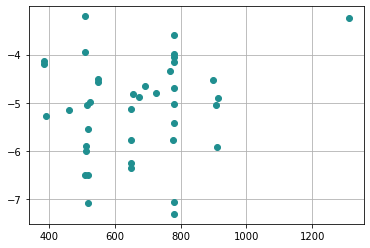

In [49]:
plt.scatter(lifetime, my_vars)

In [26]:
snl_dict.keys()

dict_keys(['SNL_18650_NCA_15C_0-100_0.5-1C_a', 'SNL_18650_NCA_15C_0-100_0.5-1C_b', 'SNL_18650_NCA_15C_0-100_0.5-2C_a', 'SNL_18650_NCA_15C_0-100_0.5-2C_b', 'SNL_18650_NCA_25C_0-100_0.5-0.5C_a', 'SNL_18650_NCA_25C_0-100_0.5-0.5C_b', 'SNL_18650_NCA_25C_0-100_0.5-1C_a', 'SNL_18650_NCA_25C_0-100_0.5-1C_b', 'SNL_18650_NCA_25C_0-100_0.5-1C_c', 'SNL_18650_NCA_25C_0-100_0.5-1C_d', 'SNL_18650_NCA_25C_0-100_0.5-2C_a', 'SNL_18650_NCA_25C_0-100_0.5-2C_b', 'SNL_18650_NCA_35C_0-100_0.5-1C_a', 'SNL_18650_NCA_35C_0-100_0.5-1C_b', 'SNL_18650_NCA_35C_0-100_0.5-1C_c', 'SNL_18650_NCA_35C_0-100_0.5-1C_d', 'SNL_18650_NCA_35C_0-100_0.5-2C_a', 'SNL_18650_NCA_35C_0-100_0.5-2C_b', 'SNL_18650_NMC_15C_0-100_0.5-1C_a', 'SNL_18650_NMC_15C_0-100_0.5-1C_b', 'SNL_18650_NMC_15C_0-100_0.5-2C_a', 'SNL_18650_NMC_15C_0-100_0.5-2C_b', 'SNL_18650_NMC_25C_0-100_0.5-0.5C_a', 'SNL_18650_NMC_25C_0-100_0.5-0.5C_b', 'SNL_18650_NMC_25C_0-100_0.5-1C_a', 'SNL_18650_NMC_25C_0-100_0.5-1C_b', 'SNL_18650_NMC_25C_0-100_0.5-1C_c', 'SNL_1865

In [31]:
test_bat = snl_dict['SNL_18650_NMC_25C_0-100_0.5-0.5C_b']

In [32]:
test_bat.keys()

dict_keys(['Cell geometry', 'Cathode chemistry', 'Temperature', 'SOL interval', 'Charging rate', 'Discharging rate', 'Cycles', 'Max Qdischarge [Ah]', '10th Vch [V]', '10th Ich [A]', '10th Qch [Ah]', '10th Vdch [V]', '10th Idch [A]', '10th Qdch [Ah]', '100th Vch [V]', '100th Ich [A]', '100th Qch [Ah]', '100th Vdch [V]', '100th Idch [A]', '100th Qdch [Ah]', 'overpotential', 'c_eff'])

In [40]:
from scipy import interpolate

In [35]:
def get_capacity_spline(cell, start_point, stop_point, use_tenth = True):
    """
    splines the voltage capacity curve
    """
    if use_tenth:
        
        v_curve, q_curve = cell['10th Vdch [V]'],cell['10th Qdch [Ah]']
    else:
        v_curve, q_curve = cell['100th Vdch [V]'],cell['100th Qdch [Ah]']
    f = interpolate.interp1d(v_curve, q_curve, fill_value="extrapolate")
    points = np.linspace(stop_point, start_point, num=1000)
    spline = f(points)
    spline[np.where(np.isnan(spline))] = 0
    return spline

In [41]:
cur_bat = test_bat

In [44]:
min_voltage = np.maximum(cur_bat['100th Vdch [V]'].min(), cur_bat['10th Vdch [V]'].min())
max_voltage = np.minimum(cur_bat['100th Vdch [V]'].max(), cur_bat['10th Vdch [V]'].max())
start_curve = get_capacity_spline(cur_bat, min_voltage, max_voltage, use_tenth = True)
stop_curve = get_capacity_spline(cur_bat, min_voltage, max_voltage, use_tenth = False)
variance = start_curve - stop_curve

In [ ]:
ge

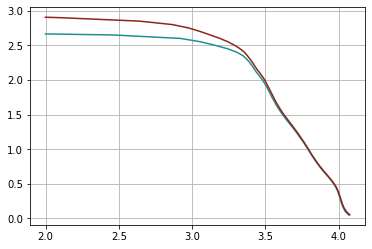

In [34]:
plt.plot(test_bat['100th Vdch [V]'], test_bat['100th Qdch [Ah]'])
plt.plot(test_bat['10th Vdch [V]'], test_bat['10th Qdch [Ah]'])

In [35]:
snl_dict['SNL_18650_LFP_15C_0-100_0.5-1C_a']['10th Vdch [V]'].shape

(29,)

In [33]:
snl_dict['SNL_18650_LFP_15C_0-100_0.5-1C_a']['10th Qch [Ah]']

(62,)

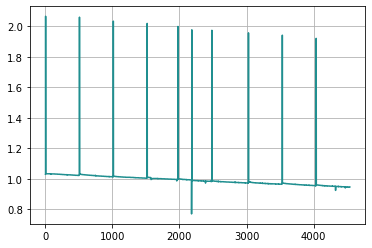

In [21]:
plt.plot(snl_dict['SNL_18650_LFP_15C_0-100_0.5-1C_a']['Max Qdischarge [Ah]'])

In [14]:
snl_dict.keys()

dict_keys(['SNL_18650_LFP_15C_0-100_0.5-1C_a', 'SNL_18650_LFP_15C_0-100_0.5-1C_b', 'SNL_18650_LFP_15C_0-100_0.5-2C_a', 'SNL_18650_LFP_15C_0-100_0.5-2C_b', 'SNL_18650_LFP_25C_0-100_0.5-0.5C_a', 'SNL_18650_LFP_25C_0-100_0.5-1C_a', 'SNL_18650_LFP_25C_0-100_0.5-1C_b', 'SNL_18650_LFP_25C_0-100_0.5-1C_c', 'SNL_18650_LFP_25C_0-100_0.5-1C_d', 'SNL_18650_LFP_25C_0-100_0.5-2C_a', 'SNL_18650_LFP_25C_0-100_0.5-2C_b', 'SNL_18650_LFP_25C_0-100_0.5-3C_a', 'SNL_18650_LFP_25C_0-100_0.5-3C_b', 'SNL_18650_LFP_25C_0-100_0.5-3C_c', 'SNL_18650_LFP_25C_0-100_0.5-3C_d', 'SNL_18650_LFP_35C_0-100_0.5-1C_a', 'SNL_18650_LFP_35C_0-100_0.5-1C_b', 'SNL_18650_LFP_35C_0-100_0.5-1C_c', 'SNL_18650_LFP_35C_0-100_0.5-1C_d', 'SNL_18650_LFP_35C_0-100_0.5-2C_a', 'SNL_18650_LFP_35C_0-100_0.5-2C_b', 'SNL_18650_NCA_15C_0-100_0.5-1C_a', 'SNL_18650_NCA_15C_0-100_0.5-1C_b', 'SNL_18650_NCA_15C_0-100_0.5-2C_a', 'SNL_18650_NCA_15C_0-100_0.5-2C_b', 'SNL_18650_NCA_25C_0-100_0.5-0.5C_a', 'SNL_18650_NCA_25C_0-100_0.5-0.5C_b', 'SNL_18650_